In [ ]:
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import sklearn.datasets as ds
import sklearn.model_selection as cv
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    VotingClassifier,    
)

%matplotlib inline

In [95]:
url = "./data_balanced_normalized.csv"
df = pd.read_csv(url)

X = df.loc[:, df.columns != 'heart_attack']
y = df['heart_attack'] 

## 50/50 instead of 70/30 - explained in report
(X_train, X_test, y_train, y_test) = cv.train_test_split(X, y, test_size = .5, random_state=1, stratify=y) 

print(f"Total samples: {df.shape[0]}")
print(y.value_counts(normalize=True)) # to see if the heart-attack class is balanced

Total samples: 127030
heart_attack
0    0.50011
1    0.49989
Name: proportion, dtype: float64


In [96]:
def compute_executions_time(function):
    def wrapper():
        start_time = time.time()  # init measuring time
        function()  # execute function
        print(f"\n{time.time() - start_time} seconds") 
    return wrapper

In [ ]:
from sklearn.calibration import cross_val_predict
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier

# Define parameters for GridSearchCV
params = {
    "n_neighbors": list(range(1, 20, 2)),
    "weights": ('distance', 'uniform'),
    "p": list(range(1, 3))
}

knc = KNeighborsClassifier()
recall_scorer = make_scorer(recall_score, pos_label=1)

# Select top 8 features using mutual information
## We are reducing dimensionality before fitting the KNN model, which can improve accuracy and efficiency
selector = SelectKBest(score_func=mutual_info_classif, k=8)
X_reduced = selector.fit_transform(X_train, y_train)

cv = 5

# Set up GridSearchCV with recall scoring
clf = GridSearchCV(
    knc,
    param_grid=params,
    cv=cv,
    scoring=recall_scorer,  
    n_jobs=-1,
    return_train_score=True 
)

# Fit GridSearchCV on the reduced training data
clf.fit(X_reduced, y_train)

# Get cross-validated predictions on the training set
y_pred_train = cross_val_predict(
    clf.best_estimator_,  # Use the best model found by GridSearchCV
    X_reduced,
    y_train,
    cv=cv
)

print("Best Hyperparameters:", clf.best_params_)
print("Mean Cross-Validated Recall (Training):", clf.best_score_)

Best Hyperparameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Mean Cross-Validated Recall (Training): 0.7866141732283465


In [104]:
best_params = clf.best_params_

clf1 = GaussianNB()

clf2 = KNeighborsClassifier(
    n_neighbors=best_params["n_neighbors"],
    weights=best_params["weights"],
    p=best_params["p"]
)

clf3 = DecisionTreeClassifier(criterion="entropy", random_state=1)
clf4 = LinearSVC(C=5, random_state=1, max_iter=10000)

classifiers = [clf1, clf2, clf3, clf4]

labels = [
    "Naive Bayes",
    f"KNN (n_neighbors={best_params['n_neighbors']}, weights={best_params['weights']}, p={best_params['p']})",
    "Decision Tree",
    "Linear SVM"
]

for clf, label in zip(classifiers, labels):
    scores = cross_val_score(
        clf,
        X_reduced,
        y_train,
        cv=cv,
        scoring="recall",
        n_jobs=-1
    )
    print(f"Recall: {scores.mean():.3f} [{label}]")


Recall: 0.802 [Naive Bayes]
Recall: 0.787 [KNN (n_neighbors=5, weights=distance, p=1)]
Recall: 0.790 [Decision Tree]
Recall: 0.801 [Linear SVM]


In [66]:
from sklearn.calibration import CalibratedClassifierCV


modelGaussianNB = GaussianNB()
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')
modelDT = DecisionTreeClassifier(criterion='entropy', random_state=1)
modelSVM = LinearSVC(C=5, max_iter=10000,random_state=1) 
## Does not work so we will use hard voting
modelSVM_calibrated = CalibratedClassifierCV(modelSVM, cv=5) ##to use soft voting


# Create VotingClassifier with these estimators
metaVoting = VotingClassifier(
    estimators=[
        ("GNB", modelGaussianNB),
        ("KNN", modelKNN),
        ("DT", modelDT),
        ("SVM", modelSVM)
    ],
    voting="hard" 
)

# Define param grid to tune weights for each classifier
params = {
    "weights": [
        [1, 1, 1, 1],
        [2, 1, 1, 1],
        [1, 2, 1, 1],
        [1, 1, 2, 1],
        [1, 1, 1, 2],
        [2, 2, 1, 1],
        [1, 2, 2, 1],
        [1, 1, 2, 2],
        [2, 1, 1, 2],
        [2, 1, 2, 2], ## best weight
        [2, 1, 3, 2],
        [2, 2, 2, 3],
        [3, 2, 3, 3],
        [3, 1, 3, 3]
    ]
}

# Create GridSearchCV on the VotingClassifier
modelVoting = GridSearchCV(
    metaVoting,
    param_grid=params,
    cv=5,
    scoring="recall", 
    n_jobs=-1
)

modelVoting.fit(X_train, y_train)

print(f"Best Params for VotingClassifier = {modelVoting.best_params_} - Recall = {modelVoting.best_score_:.4f}")

Best Params for VotingClassifier = {'weights': [2, 1, 2, 2]} - Recall = 0.8165


In [ ]:
eclf = VotingClassifier(
    estimators=[
        ("nb", clf1), 
        ("knn", clf2), 
        ("dt", clf3),
        ("svm", clf4)
    ],
    voting = "hard")
scores = cross_val_score(
    eclf, 
    X_train, 
    y_train, 
    cv = cv, 
    scoring = "recall"
)
print("Recall: %0.3f [%s]" % (scores.mean() , "Majority Voting (hard)")) 

Recall: 0.751 [Majority Voting (hard)]


In [116]:
## soft voting
clf4_calibrated = CalibratedClassifierCV(clf4, cv=5)

eclf = VotingClassifier(
    estimators=[('nb', clf1), ('knn', clf2), ('dt', clf3), ('svm', clf4_calibrated)],
    voting='soft', 
    weights=[2,1,2,2] ##found with test in the code 
)
scores = cross_val_score(
    eclf,
    X_train,
    y_train, 
    cv=cv, 
    scoring='recall'
)
print("Recall: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Recall: 0.800 [Weighted Voting]


In [117]:
## hard voting
eclf = VotingClassifier(
    estimators=[('nb', clf1), ('knn', clf2), ('dt', clf3), ('svm', clf4)],
    voting='hard', 
    weights=[2,1,2,2] ##found with test in the code 
)
scores = cross_val_score(
    eclf,
    X_train,
    y_train, 
    cv=cv, 
    scoring='recall'
)
print("Recall: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Recall: 0.817 [Weighted Voting]


In [109]:
## Best parameters for Knn
def mutual_info_with_seed(X, y):
    return mutual_info_classif(X, y, random_state=1)

selector = SelectKBest(score_func=mutual_info_classif, k=8)
X_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)  
modelKNN = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance').fit(X_reduced, y_train) 

modelGaussianNB = GaussianNB().fit(X_train, y_train)
modelSVM = LinearSVC(C=5, max_iter=10000, random_state=1).fit(X_train, y_train)
modelDT = DecisionTreeClassifier(criterion='entropy', random_state=1).fit(X_train, y_train)

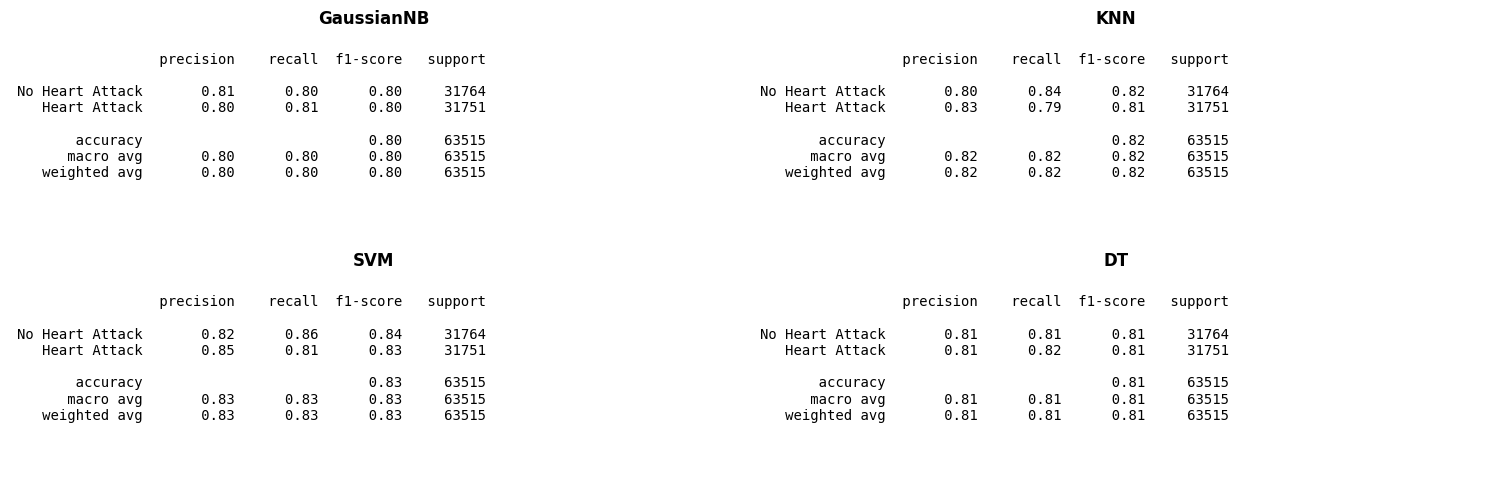

In [110]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

target_names = ['No Heart Attack', 'Heart Attack']

reportGNB = classification_report(y_test, modelGaussianNB.predict(X_test), target_names=target_names)
reportKNN = classification_report(y_test, modelKNN.predict(X_test_reduced), target_names=target_names)
reportSVM = classification_report(y_test, modelSVM.predict(X_test), target_names=target_names)
reportDT = classification_report(y_test, modelDT.predict(X_test), target_names=target_names)


reports = [reportGNB, reportKNN, reportSVM, reportDT]
titles = ['GaussianNB', 'KNN', 'SVM', 'DT']

fig, axes = plt.subplots(2, 2, figsize=(15, 5))
axes = axes.flatten()

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.90,
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    )
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


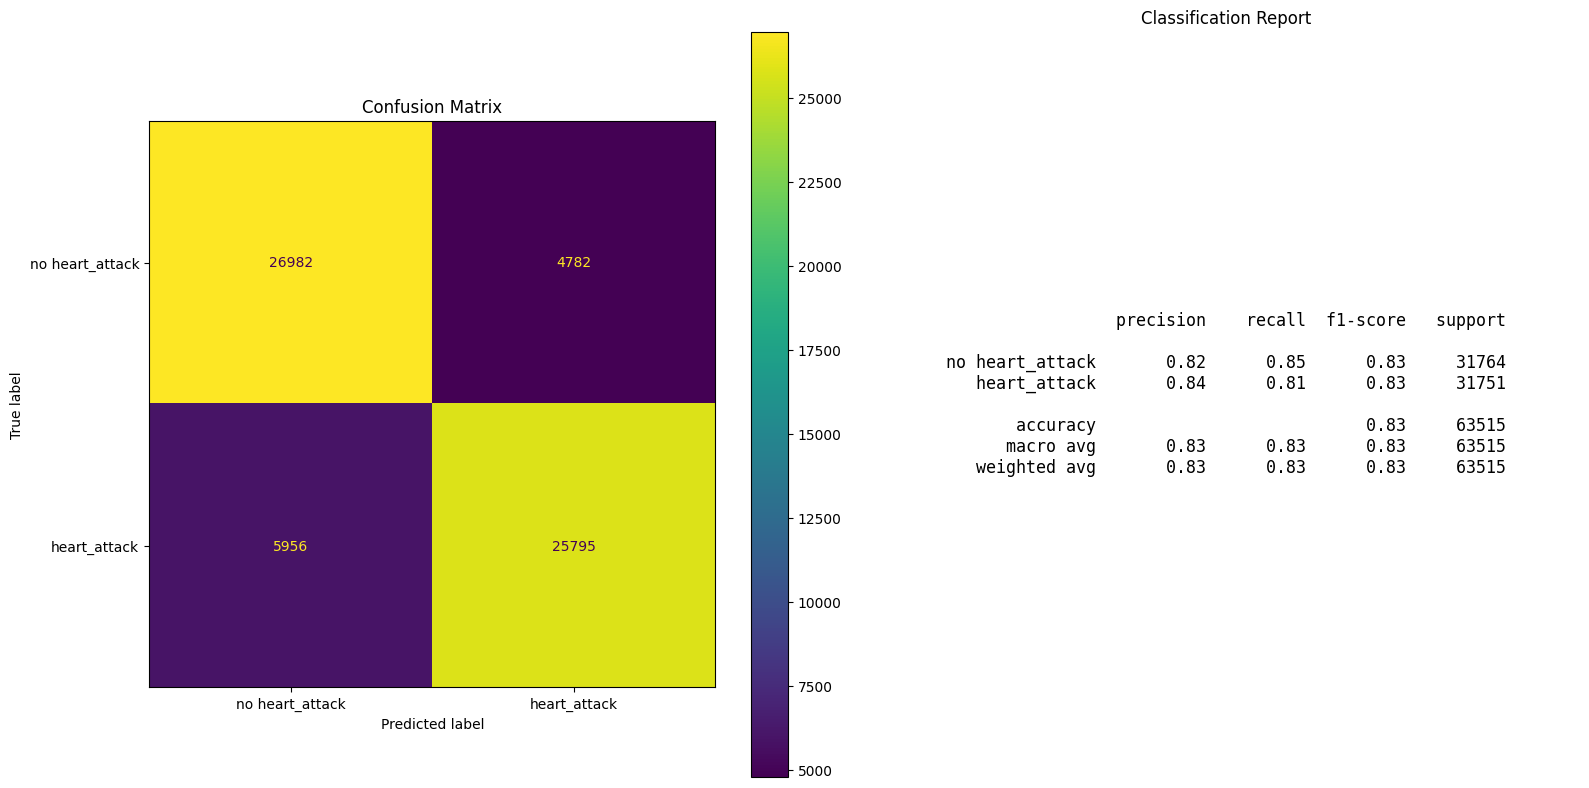

In [111]:
from sklearn.metrics import ConfusionMatrixDisplay

report = classification_report(
    y_test, 
    modelVoting.best_estimator_.predict(X_test), 
    target_names=['no heart_attack', 'heart_attack']
)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ConfusionMatrixDisplay.from_estimator(
    modelVoting.best_estimator_, 
    X_test, 
    y_test, 
    display_labels=['no heart_attack', 'heart_attack'], 
    ax=axes[0],
)
axes[0].set_title('Confusion Matrix')
axes[1].axis('off')
axes[1].text(0.5, 0.5, report, fontsize=12, ha='center', va='center', family='monospace')
axes[1].set_title('Classification Report')
plt.tight_layout()
plt.show()

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.proportion import proportion_confint


acc      = accuracy_score(y_test, y_pred)
prec_pos = precision_score(y_test, y_pred, pos_label=1)
rec_pos  = recall_score(y_test, y_pred,    pos_label=1)


tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
n_total   = tp + tn + fp + fn        


acc_ci   = proportion_confint(count=tp + tn, nobs=n_total,   alpha=0.05, method="wilson")
prec_ci  = proportion_confint(count=tp,       nobs=tp + fp,  alpha=0.05, method="wilson")
rec_ci   = proportion_confint(count=tp,       nobs=tp + fn,  alpha=0.05, method="wilson")

normal_ok = n_total * acc * (1 - acc) >= 5

print(f"Accuracy     : {acc:.3f}  (95% CI {acc_ci[0]:.3f} - {acc_ci[1]:.3f})")
print(f"Precision (1): {prec_pos:.3f}  (95% CI {prec_ci[0]:.3f} - {prec_ci[1]:.3f})")
print(f"Recall    (1): {rec_pos:.3f}  (95% CI {rec_ci[0]:.3f} - {rec_ci[1]:.3f})")


Accuracy     : 0.812  (95% CI 0.809 - 0.815)
Precision (1): 0.810  (95% CI 0.806 - 0.815)
Recall    (1): 0.815  (95% CI 0.811 - 0.819)


## **Bagging**

In [ ]:

for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(), 
            n_estimators = nest,
            random_state=1
        ), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring= 'recall'
    )
    print(f"Recall DT: {scores.mean():.3f} [nº estimators: {nest}]")


Recall DT: 0.808 [nº estimators: 1]
Recall DT: 0.731 [nº estimators: 2]
Recall DT: 0.811 [nº estimators: 5]
Recall DT: 0.791 [nº estimators: 10]
Recall DT: 0.799 [nº estimators: 20]
Recall DT: 0.803 [nº estimators: 50]
Recall DT: 0.804 [nº estimators: 100]
Recall DT: 0.805 [nº estimators: 200]


In [ ]:
for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator = DecisionTreeClassifier(),
            n_estimators = nest,
            max_features = 0.35,
            random_state=1
        ), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring="recall"
    )
    print(f"Recall: {scores.mean():.3f} [nº estimators: {nest}]")


Recall: 0.597 [nº estimators: 1]
Recall: 0.319 [nº estimators: 2]
Recall: 0.627 [nº estimators: 5]
Recall: 0.692 [nº estimators: 10]
Recall: 0.743 [nº estimators: 20]
Recall: 0.780 [nº estimators: 50]
Recall: 0.788 [nº estimators: 100]
Recall: 0.790 [nº estimators: 200]


In [69]:
##best parameters for knn
selector = SelectKBest(score_func=mutual_info_classif, k=8)
X_train_reduced = selector.fit_transform(X_train, y_train)

def bagging(model, name, newX):
    for nest in [1,2,5,10,20,50,100]:
        scores = cross_val_score(
            BaggingClassifier(
                estimator = model,
                n_estimators = nest,
                random_state = 1
            ), 
            newX, 
            y_train, 
            cv = 5, 
            scoring = "recall"
        )
        print("Recall %s: %0.3f [%s]" % (name, scores.mean(), nest))
    
bagging(GaussianNB(), "GNB", X_train)
print()
bagging(KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance'), "KNN", X_train_reduced)

print()    

Recall GNB: 0.811 [1]
Recall GNB: 0.811 [2]
Recall GNB: 0.810 [5]
Recall GNB: 0.809 [10]
Recall GNB: 0.810 [20]
Recall GNB: 0.810 [50]
Recall GNB: 0.810 [100]

Recall KNN: 0.784 [1]
Recall KNN: 0.786 [2]
Recall KNN: 0.786 [5]
Recall KNN: 0.786 [10]
Recall KNN: 0.787 [20]
Recall KNN: 0.786 [50]
Recall KNN: 0.787 [100]



In [40]:
for nest in [1, 2, 5, 10, 20, 50, 100]:
    scores = cross_val_score(
        BaggingClassifier(
            estimator=LinearSVC(C=5, max_iter=10000, random_state=1),
            n_estimators=nest,
            random_state=1
        ), 
        X_train, 
        y_train, 
        cv=5, 
        scoring="recall"
    )
    print("Recall %s: %0.3f [%s]" % ("LinearSVC", scores.mean(), nest))


Recall LinearSVC: 0.808 [1]
Recall LinearSVC: 0.803 [2]
Recall LinearSVC: 0.809 [5]
Recall LinearSVC: 0.808 [10]
Recall LinearSVC: 0.809 [20]
Recall LinearSVC: 0.810 [50]
Recall LinearSVC: 0.810 [100]


In [70]:
## n_estimators depending of the results found earlier
modelBaggingDT = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=1).fit(X_train, y_train)
modelBaggingGaussianNB = BaggingClassifier(estimator=GaussianNB(),n_estimators=20,random_state=1).fit(X_train, y_train)
modelBaggingKNN = BaggingClassifier(estimator=KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance'),n_estimators=20,random_state=1).fit(X_train_reduced, y_train)
modelBaggingSVM = BaggingClassifier(estimator=LinearSVC(C=5, max_iter=10000), n_estimators=50, random_state=1).fit(X_train, y_train)

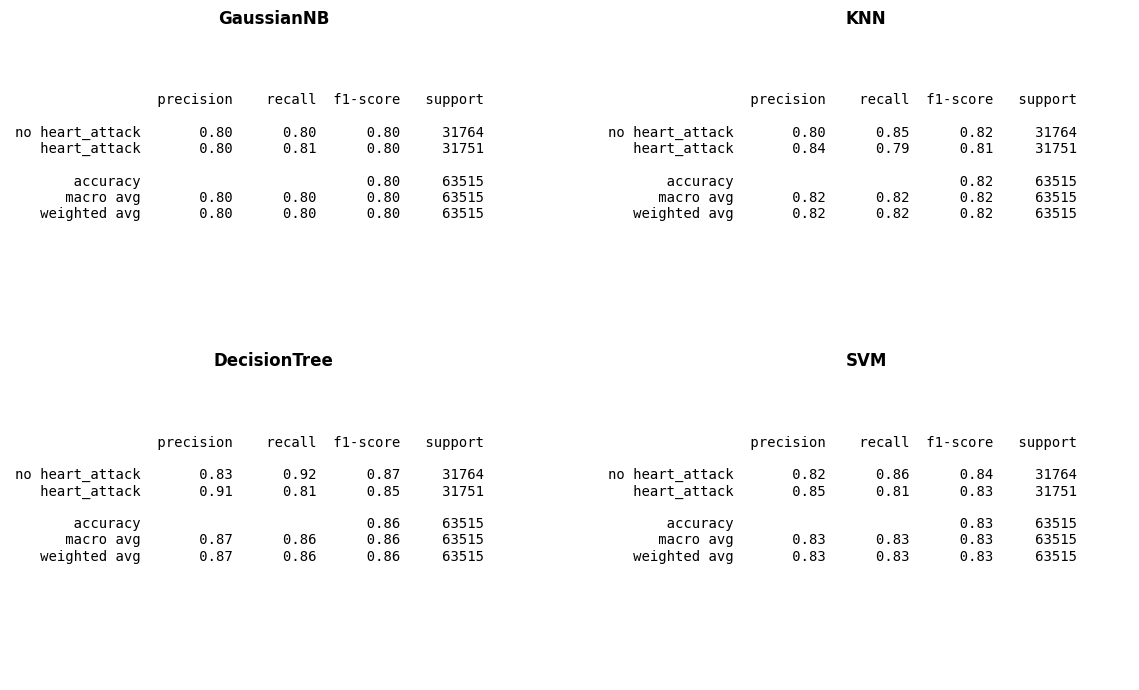

In [ ]:
reportBaggingGNB = classification_report(y_test, modelBaggingGaussianNB.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportBaggingKNN = classification_report(y_test, modelBaggingKNN.predict(X_test_reduced), target_names=['no heart_attack', 'heart_attack'])
reportBaggingSVM = classification_report(y_test, modelBaggingSVM.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportBaggingDT = classification_report(y_test, modelBaggingDT.predict(X_test), target_names=['no heart_attack', 'heart_attack'])


reports = [reportBaggingGNB, reportBaggingKNN, reportBaggingDT, reportBaggingSVM]
titles = ['GaussianNB', 'KNN', 'DecisionTree', 'SVM']
fig, axes = plt.subplots(2, 2, figsize=(12, 7)) 
axes = axes.flatten()  

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.80, 
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

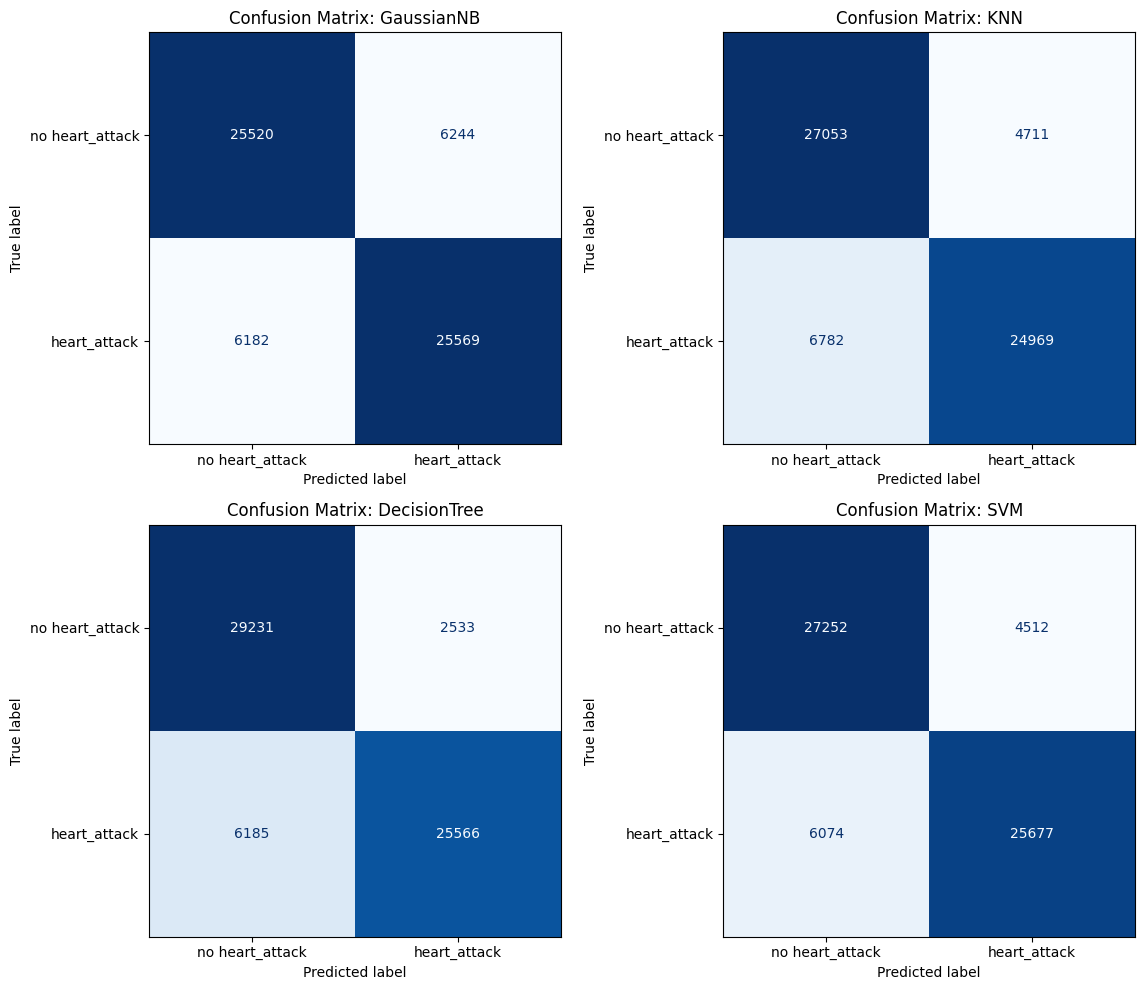

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay

models = [modelBaggingGaussianNB, modelBaggingKNN, modelBaggingDT, modelBaggingSVM]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (model, title) in enumerate(zip(models, titles)):
    X_test_modified = X_test_reduced if title == 'KNN' else X_test  #Use reduced test set for KNN
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test_modified,
        y_test,
        display_labels=['no heart_attack', 'heart_attack'],
        ax=axes[i],
        cmap='Blues',
        colorbar=False
    )
    axes[i].set_title(f'Confusion Matrix: {title}')

plt.tight_layout()
plt.show()


In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.proportion import proportion_confint

def printCI(model, X_test):
    y_pred = model.predict(X_test)

    acc      = accuracy_score(y_test, y_pred)
    prec_pos = precision_score(y_test, y_pred, pos_label=1)
    rec_pos  = recall_score(y_test, y_pred,    pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    n_total   = tp + tn + fp + fn        

    acc_ci   = proportion_confint(count=tp + tn, nobs=n_total,   alpha=0.05, method="wilson")
    prec_ci  = proportion_confint(count=tp,       nobs=tp + fp,  alpha=0.05, method="wilson")
    rec_ci   = proportion_confint(count=tp,       nobs=tp + fn,  alpha=0.05, method="wilson")

    print(f"Accuracy     : {acc:.3f}  (95% CI {acc_ci[0]:.3f} - {acc_ci[1]:.3f})")
    print(f"Precision : {prec_pos:.3f}  (95% CI {prec_ci[0]:.3f} - {prec_ci[1]:.3f})")
    print(f"Recall   : {rec_pos:.3f}  (95% CI {rec_ci[0]:.3f} - {rec_ci[1]:.3f})")

print("GNB:")
printCI(modelBaggingGaussianNB, X_test)

print("\nKNN:")
printCI(modelBaggingKNN, X_test_reduced)

print("\nDT:")
printCI(modelBaggingDT, X_test)

print("\nSVM:")
printCI(modelBaggingSVM, X_test)


GNB:
Accuracy     : 0.804  (95% CI 0.801 - 0.807)
Precision : 0.804  (95% CI 0.799 - 0.808)
Recall   : 0.805  (95% CI 0.801 - 0.810)

KNN:
Accuracy     : 0.819  (95% CI 0.816 - 0.822)
Precision : 0.841  (95% CI 0.837 - 0.845)
Recall   : 0.786  (95% CI 0.782 - 0.791)

DT:
Accuracy     : 0.863  (95% CI 0.860 - 0.865)
Precision : 0.910  (95% CI 0.906 - 0.913)
Recall   : 0.805  (95% CI 0.801 - 0.810)

SVM:
Accuracy     : 0.833  (95% CI 0.830 - 0.836)
Precision : 0.851  (95% CI 0.846 - 0.855)
Recall   : 0.809  (95% CI 0.804 - 0.813)


## **Random Forest**

In [44]:
random_forest_classifier = RandomForestClassifier(
    n_estimators = 100
)

random_forest_classifier.fit(X_train, y_train)
print(f"Random Forest Score (Train): {random_forest_classifier.score(X_train, y_train)}")
print(f"Random Forest Score (Test):  {random_forest_classifier.score(X_test, y_test)}")

Random Forest Score (Train): 1.0
Random Forest Score (Test):  0.8637644650869873


In [45]:
random_forest_classifier = RandomForestClassifier(
    n_estimators = 200
)

random_forest_classifier.fit(X_train, y_train)
print(f"Random Forest Score (Train): {random_forest_classifier.score(X_train, y_train)}")
print(f"Random Forest Score (Test):  {random_forest_classifier.score(X_test, y_test)}")

Random Forest Score (Train): 1.0
Random Forest Score (Test):  0.8648193340155869


In [91]:
@compute_executions_time
def execute_random_forest_with_different_estimators_and_cv(cv=5):
    for n_trees in [1, 2, 5, 10, 20, 50, 100, 200]:
        random_forest_classifier = RandomForestClassifier(
            n_estimators = n_trees,
            random_state = 1
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=cv,
            scoring="recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators (trees): {n_trees}]")
        
execute_random_forest_with_different_estimators_and_cv();

Recall: 0.775 [nº estimators (trees): 1]
Recall: 0.650 [nº estimators (trees): 2]
Recall: 0.810 [nº estimators (trees): 5]
Recall: 0.789 [nº estimators (trees): 10]
Recall: 0.802 [nº estimators (trees): 20]
Recall: 0.808 [nº estimators (trees): 50]
Recall: 0.811 [nº estimators (trees): 100]
Recall: 0.813 [nº estimators (trees): 200]

286.5137851238251 seconds


In [89]:
@compute_executions_time
def run_extra_trees_cv_experiment(cv=5):
    for n_trees in [1, 2, 5, 10, 20, 50, 100, 200, 300, 400]:
        random_forest_classifier = ExtraTreesClassifier(
            n_estimators = n_trees,
            random_state = 1
        )
        scores = cross_val_score(
            estimator = random_forest_classifier,
            X = X_train,
            y = y_train,
            cv=cv,
            scoring="recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators (trees): {n_trees}]")
        
run_extra_trees_cv_experiment();

Recall: 0.754 [nº estimators (trees): 1]
Recall: 0.617 [nº estimators (trees): 2]
Recall: 0.786 [nº estimators (trees): 5]
Recall: 0.759 [nº estimators (trees): 10]
Recall: 0.776 [nº estimators (trees): 20]
Recall: 0.783 [nº estimators (trees): 50]
Recall: 0.787 [nº estimators (trees): 100]
Recall: 0.789 [nº estimators (trees): 200]
Recall: 0.789 [nº estimators (trees): 300]
Recall: 0.790 [nº estimators (trees): 400]

290.2509546279907 seconds


In [ ]:
## n_estimators = 200 - see in report
modelRandomForest = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
modelExtraTrees = ExtraTreesClassifier(n_estimators=200).fit(X_train, y_train)

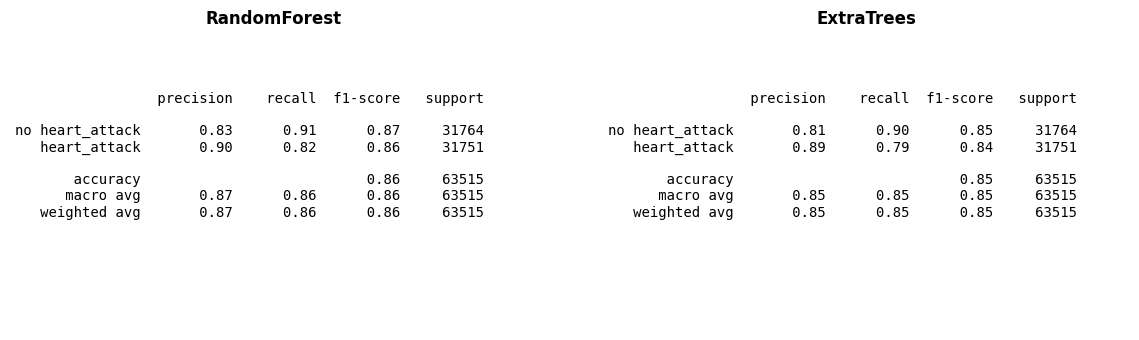

In [62]:
reportRandomForest = classification_report(y_test, modelRandomForest.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportExtraTrees = classification_report(y_test, modelExtraTrees.predict(X_test), target_names=['no heart_attack', 'heart_attack'])

reports = [reportRandomForest, reportExtraTrees]
titles = ['RandomForest', 'ExtraTrees']
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5)) 

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.80,  
        report,
        fontsize=10,
        family='monospace',
        horizontalalignment='left',
        verticalalignment='top'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

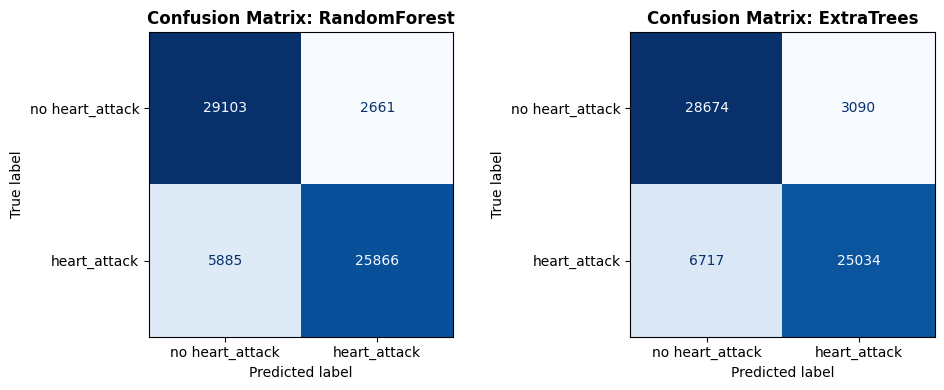

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay

models = [modelRandomForest, modelExtraTrees]
titles = ['RandomForest', 'ExtraTrees']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

for i, (model, title) in enumerate(zip(models, titles)):
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=['no heart_attack', 'heart_attack'],
        ax=axes[i],
        cmap='Blues',
        colorbar=False
    )
    axes[i].set_title(f'Confusion Matrix: {title}', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.proportion import proportion_confint

def printCI(model):
    y_pred = model.predict(X_test)

    acc      = accuracy_score(y_test, y_pred)
    prec_pos = precision_score(y_test, y_pred, pos_label=1)
    rec_pos  = recall_score(y_test, y_pred,    pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    n_total   = tp + tn + fp + fn        

    acc_ci   = proportion_confint(count=tp + tn, nobs=n_total,   alpha=0.05, method="wilson")
    prec_ci  = proportion_confint(count=tp,       nobs=tp + fp,  alpha=0.05, method="wilson")
    rec_ci   = proportion_confint(count=tp,       nobs=tp + fn,  alpha=0.05, method="wilson")

    normal_ok = n_total * acc * (1 - acc) >= 5

    print(f"Accuracy     : {acc:.3f}  (95% CI {acc_ci[0]:.3f} - {acc_ci[1]:.3f})")
    print(f"Precision : {prec_pos:.3f}  (95% CI {prec_ci[0]:.3f} - {prec_ci[1]:.3f})")
    print(f"Recall   : {rec_pos:.3f}  (95% CI {rec_ci[0]:.3f} - {rec_ci[1]:.3f})")

print("modelRandomForest:")
printCI(modelRandomForest)

print("\nmodelExtraTrees:")
printCI(modelExtraTrees,)


modelRandomForest:
Accuracy     : 0.865  (95% CI 0.863 - 0.868)
Precision : 0.907  (95% CI 0.903 - 0.910)
Recall   : 0.815  (95% CI 0.810 - 0.819)

modelExtraTrees:
Accuracy     : 0.846  (95% CI 0.843 - 0.848)
Precision : 0.890  (95% CI 0.886 - 0.894)
Recall   : 0.788  (95% CI 0.784 - 0.793)


In [51]:
from statsmodels.stats.contingency_tables import mcnemar

# Get predictions from both models
pred_rf = modelRandomForest.predict(X_test)
pred_et = modelExtraTrees.predict(X_test)

both_correct = (y_test == pred_rf) & (y_test == pred_et)
only_et_correct = (y_test != pred_rf) & (y_test == pred_et)
only_rf_correct = (y_test == pred_rf) & (y_test != pred_et)
both_wrong = (y_test != pred_rf) & (y_test != pred_et)

table_data = {
    'ExtraTrees Correct': [both_correct.sum(), only_rf_correct.sum()],
    'ExtraTrees Wrong': [only_et_correct.sum(), both_wrong.sum()]
}
index_labels = ['RandomForest Correct', 'RandomForest Wrong']
contingency_df = pd.DataFrame(table_data, index=index_labels)

print("\n Contingency Table:\n")
print(contingency_df)

results_mcnemar = mcnemar(contingency_df.values, exact=False, correction=True)

print("\n McNemar Test Results:")
print(f"Statistics value: {results_mcnemar.statistic}")
print(f"p-value: {results_mcnemar.pvalue}")


if results_mcnemar.pvalue < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis: No significant difference between the models.")



 Contingency Table:

                      ExtraTrees Correct  ExtraTrees Wrong
RandomForest Correct               52019              1611
RandomForest Wrong                  2944              6941

 McNemar Test Results:
Statistics value: 389.5113062568606
p-value: 1.0574665745610124e-86
Reject the null hypothesis


## **Ada Boost Classifier**

In [52]:
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers(cv=5):
    for n_estimators in [1, 2, 5, 10, 20, 50, 100, 200]:
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=n_estimators,
            random_state=1
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X_train,
            y_train,
            cv = cv,
            scoring = "recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators: {n_estimators}]")

execute_ada_boost_classifier_for_different_classifiers()

Recall: 0.423 [nº estimators: 1]
Recall: 0.423 [nº estimators: 2]
Recall: 0.715 [nº estimators: 5]
Recall: 0.765 [nº estimators: 10]
Recall: 0.798 [nº estimators: 20]
Recall: 0.821 [nº estimators: 50]
Recall: 0.852 [nº estimators: 100]
Recall: 0.852 [nº estimators: 200]

67.56616973876953 seconds


In [ ]:
## with cv = 10 to do compare  -- no significant change 
@compute_executions_time
def execute_ada_boost_classifier_for_different_classifiers(cv=10):
    for n_estimators in [1, 2, 5, 10, 20, 50, 100, 200]:
        ada_boos_classifier = AdaBoostClassifier(
            n_estimators=n_estimators,
            random_state=1
        )
        scores = cross_val_score(
            ada_boos_classifier,
            X,
            y,
            cv = cv,
            scoring = "recall"
        )
        print(f"Recall: {scores.mean():.3f} [nº estimators: {n_estimators}]")

execute_ada_boost_classifier_for_different_classifiers()

Recall: 0.450 [nº estimators: 1]
Recall: 0.450 [nº estimators: 2]
Recall: 0.783 [nº estimators: 5]
Recall: 0.664 [nº estimators: 10]
Recall: 0.791 [nº estimators: 20]
Recall: 0.813 [nº estimators: 50]
Recall: 0.851 [nº estimators: 100]
Recall: 0.853 [nº estimators: 200]

412.30670714378357 seconds


In [54]:
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(LinearSVC(C=5, max_iter=10000), n_estimators = n_estimators, random_state=1), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring = "recall"
    )
    print("Recall adaBoost LinearSVC: %0.3f [%s]" % (scores.mean(), n_estimators))

Recall adaBoost LinearSVC: 0.793 [1]
Recall adaBoost LinearSVC: 0.793 [2]
Recall adaBoost LinearSVC: 0.793 [5]
Recall adaBoost LinearSVC: 0.793 [10]
Recall adaBoost LinearSVC: 0.793 [20]
Recall adaBoost LinearSVC: 0.793 [50]
Recall adaBoost LinearSVC: 0.793 [100]
Recall adaBoost LinearSVC: 0.793 [200]


In [55]:
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(GaussianNB(), n_estimators = n_estimators, random_state=1), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring = "recall"
    )
    print("Recall: %0.3f [%s]" % (scores.mean(), n_estimators))
print()
for n_estimators in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators = n_estimators, random_state=1), 
        X_train, 
        y_train, 
        cv = 5, 
        scoring = "recall"
    )
    print("Recall: %0.3f [%s]" % (scores.mean(), n_estimators))

Recall: 0.810 [1]
Recall: 0.810 [2]
Recall: 0.848 [5]
Recall: 0.854 [10]
Recall: 0.854 [20]
Recall: 0.854 [50]
Recall: 0.854 [100]
Recall: 0.854 [200]

Recall: 0.765 [1]
Recall: 0.765 [2]
Recall: 0.813 [5]
Recall: 0.818 [10]
Recall: 0.825 [20]
Recall: 0.825 [50]
Recall: 0.826 [100]
Recall: 0.823 [200]


In [85]:
modelAdaboostGNB = AdaBoostClassifier(GaussianNB(), n_estimators=100, random_state=1).fit(X_train, y_train)
modelAdaboostDT = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=1).fit(X_train, y_train)
modelAdaboostSVC = AdaBoostClassifier(LinearSVC(C=5, max_iter=10000), n_estimators = 100, random_state=1).fit(X_train, y_train)

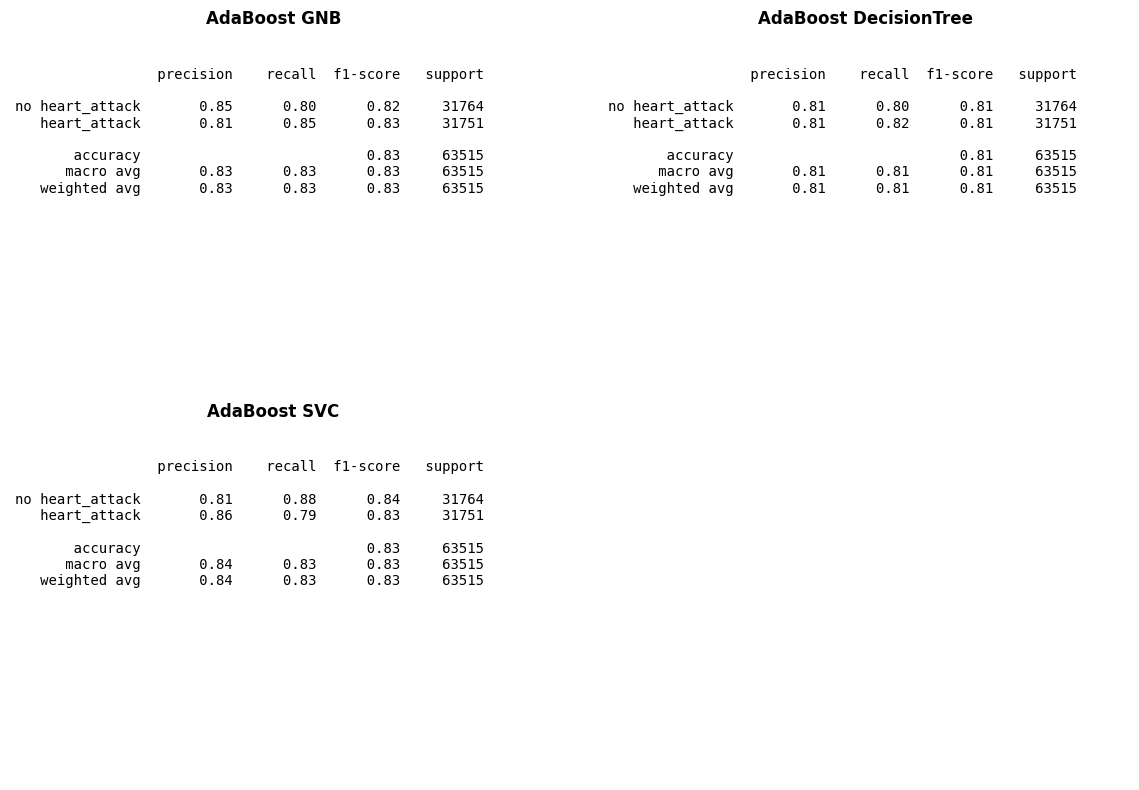

In [59]:
reportAdaboostGNB = classification_report(y_test, modelAdaboostGNB.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportAdaboostDT = classification_report(y_test, modelAdaboostDT.predict(X_test), target_names=['no heart_attack', 'heart_attack'])
reportAdaboostSVC = classification_report(y_test, modelAdaboostSVC.predict(X_test), target_names=['no heart_attack', 'heart_attack'])


reports = [reportAdaboostGNB, reportAdaboostDT, reportAdaboostSVC]
titles = ['AdaBoost GNB', 'AdaBoost DecisionTree', 'AdaBoost SVC']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  

for i, (report, title) in enumerate(zip(reports, titles)):
    axes[i].text(
        0.01, 0.90, 
        report,
        fontsize=10,
        family='monospace',
        verticalalignment='top',
        horizontalalignment='left'
    ) 
    axes[i].axis('off')  
    axes[i].set_title(title, fontsize=12, weight='bold')

    if len(reports) < len(axes):
        for j in range(len(reports), len(axes)):
            axes[j].axis('off')

plt.tight_layout()
plt.show()

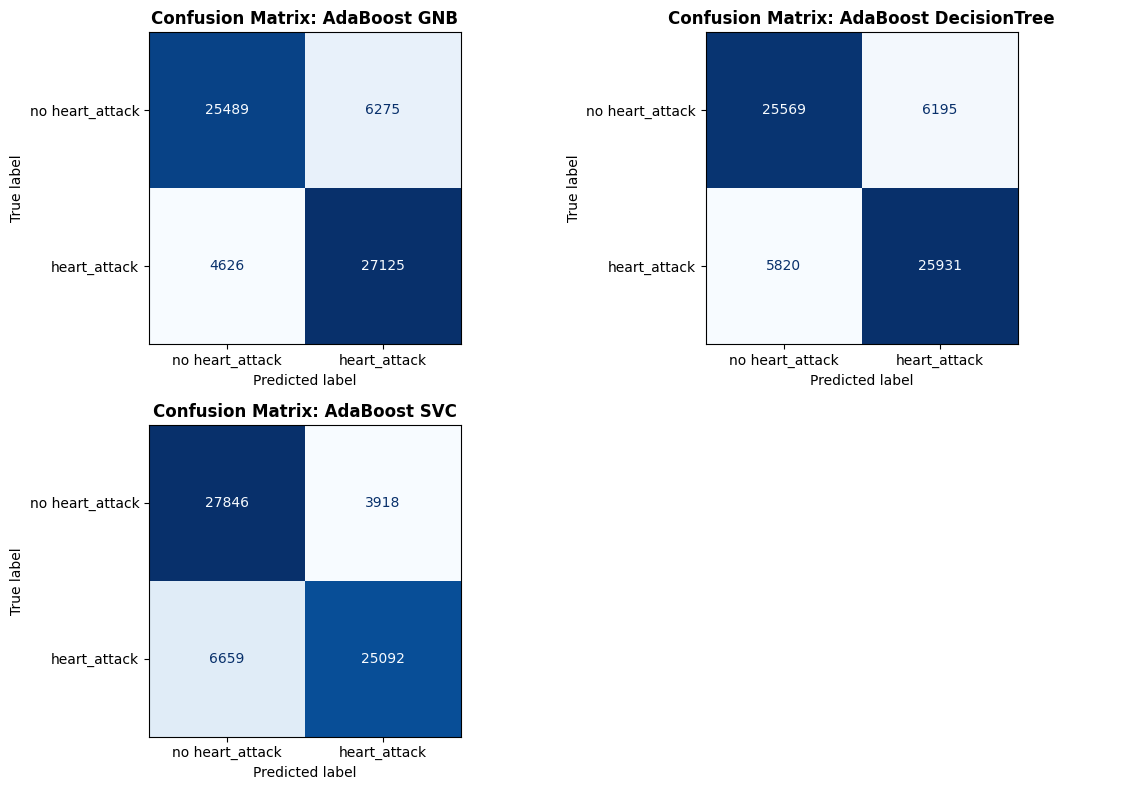

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

models = [modelAdaboostGNB, modelAdaboostDT, modelAdaboostSVC]
titles = ['AdaBoost GNB', 'AdaBoost DecisionTree', 'AdaBoost SVC']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (model, title) in enumerate(zip(models, titles)):
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=['no heart_attack', 'heart_attack'],
        ax=axes[i],
        cmap='Blues',
        colorbar=False
    )
    axes[i].set_title(f'Confusion Matrix: {title}', fontsize=12, weight='bold')

# Hide the unused subplot
if len(models) < len(axes):
    for j in range(len(models), len(axes)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()


In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.proportion import proportion_confint

def printCI(model):
    y_pred = model.predict(X_test)

    acc      = accuracy_score(y_test, y_pred)
    prec_pos = precision_score(y_test, y_pred, pos_label=1)
    rec_pos  = recall_score(y_test, y_pred,    pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    n_total   = tp + tn + fp + fn        

    acc_ci   = proportion_confint(count=tp + tn, nobs=n_total,   alpha=0.05, method="wilson")
    prec_ci  = proportion_confint(count=tp,       nobs=tp + fp,  alpha=0.05, method="wilson")
    rec_ci   = proportion_confint(count=tp,       nobs=tp + fn,  alpha=0.05, method="wilson")

    normal_ok = n_total * acc * (1 - acc) >= 5

    print(f"Accuracy     : {acc:.3f}  (95% CI {acc_ci[0]:.3f} - {acc_ci[1]:.3f})")
    print(f"Precision : {prec_pos:.3f}  (95% CI {prec_ci[0]:.3f} - {prec_ci[1]:.3f})")
    print(f"Recall   : {rec_pos:.3f}  (95% CI {rec_ci[0]:.3f} - {rec_ci[1]:.3f})")

print("Adaboost GNB:")
printCI(modelAdaboostGNB)

print("\nAdaboost DT:")
printCI(modelAdaboostDT)


print("\nAdaboost SVC:")
printCI(modelAdaboostSVC,)



Adaboost GNB:
Accuracy     : 0.828  (95% CI 0.825 - 0.831)
Precision : 0.812  (95% CI 0.808 - 0.816)
Recall   : 0.854  (95% CI 0.850 - 0.858)

Adaboost DT:
Accuracy     : 0.811  (95% CI 0.808 - 0.814)
Precision : 0.807  (95% CI 0.803 - 0.811)
Recall   : 0.817  (95% CI 0.812 - 0.821)

Adaboost SVC:
Accuracy     : 0.833  (95% CI 0.831 - 0.836)
Precision : 0.865  (95% CI 0.861 - 0.869)
Recall   : 0.790  (95% CI 0.786 - 0.795)
